<a href="https://colab.research.google.com/github/alfredoalvaradoenciso/wbg-wdi/blob/main/wdi_wbg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    countryiso3code  date     value
0               EAP  2021  7.548580
1               EAP  2021  7.548580
2               EAP  2020  1.299908
3               EAP  2019  5.782894
4               EAP  2018  6.525437
..              ...   ...       ...
164             WLD  1984  4.709696
165             WLD  1983  2.624594
166             WLD  1982  0.303379
167             WLD  1981  1.952000
168             WLD  1980  1.868604

[169 rows x 3 columns]


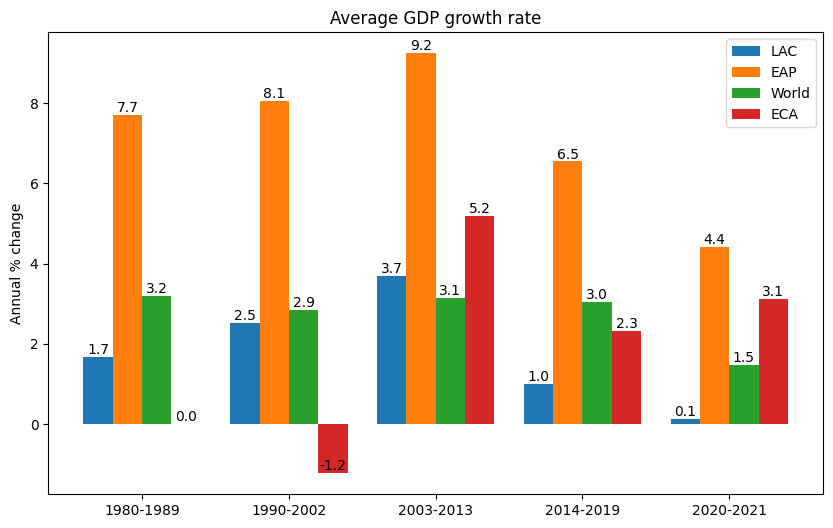

In [5]:

import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

#import wbgapi as wb   # I use wb as a namespace in all my work
import matplotlib.pyplot as plt


def extract_pages_value(url):
    response = requests.get(url)
    if response.status_code == 200:
        content = response.content.decode('utf-8')  # Decode response content as text
        first_two_lines = content.split("\n", 2)[:2]
        for line in first_two_lines:
            pages_match = re.search(r'pages="(\d+)"', line)
            if pages_match:
                pages_value = int(pages_match.group(1))
                return pages_value
    return None

# URL for the World Bank API
url = "https://api.worldbank.org/v2/country/LCN;EAP;WLD;ECA/indicator/NY.GDP.MKTP.KD.ZG?date=1980:2021"

# Extract the value of "pages"
pages_value = extract_pages_value(url)
perpage = pages_value*50
url = f"https://api.worldbank.org/v2/country/LCN;EAP;WLD;ECA/indicator/NY.GDP.MKTP.KD.ZG?date=1980:2021&per_page={perpage}"


# Make the API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    try:
        soup = BeautifulSoup(response.content, "xml")

        # Extract the relevant data from the API response
        extracted_data = []
        for data_element in soup.find_all("data"):
            countryiso3code = data_element.find("countryiso3code").text
            date = int(data_element.find("date").text)
            value = data_element.find("value").text
            if value.strip() == "":
                value = None
            else:
                value = float(value)
            extracted_data.append({"countryiso3code": countryiso3code, "date": date, "value": value})

        # Create a DataFrame from the extracted data
        df = pd.DataFrame(extracted_data)
        print(df)

    except Exception as e:
        print("Error parsing XML:", e)

else:
    print("Error: Unable to fetch data from the API.")

df = df.pivot_table(index='date', columns='countryiso3code', values='value', aggfunc='first')

# Missing values
df['ECA'] = df['ECA'].fillna(0)
df.reset_index(inplace=True)

# Recode based on the specified intervals
df['date'] = pd.cut(df['date'], [1980, 1989, 2002, 2013, 2019, 2021], labels=[1, 2, 3, 4, 5])

# Define labels for 'date'
date_labels = {1: "1980-1989", 2: "1990-2002", 3: "2003-2013", 4: "2014-2019", 5: "2020-2021"}
df['date'] = df['date'].map(date_labels)

# Collapse the data by 'date' and calculate the mean of 'EAP', 'ECA', 'LCN', and 'WLD'
collapsed_data = df.groupby('date').agg({'EAP': 'mean', 'ECA': 'mean', 'LCN': 'mean', 'WLD': 'mean'}).reset_index()

width = 0.2
date_values = collapsed_data['date'].unique()
x = range(len(date_values))

%matplotlib inline

plt.figure(figsize=(10, 6))
plt.bar(x, collapsed_data['LCN'], width=width, label="LAC")
plt.bar([i + width for i in x], collapsed_data['EAP'], width=width, label="EAP")
plt.bar([i + 2 * width for i in x], collapsed_data['WLD'], width=width, label="World")
plt.bar([i + 3 * width for i in x], collapsed_data['ECA'], width=width, label="ECA")

plt.xlabel("")
plt.ylabel("Annual % change")
plt.title("Average GDP growth rate")
plt.xticks([i + 1.5 * width for i in x], date_values)
plt.legend()

# Annotate the bars with their values
for i in x:
    plt.text(i, collapsed_data['LCN'][i], f"{collapsed_data['LCN'][i]:.1f}", ha='center', va='bottom')
    plt.text(i + width, collapsed_data['EAP'][i], f"{collapsed_data['EAP'][i]:.1f}", ha='center', va='bottom')
    plt.text(i + 2 * width, collapsed_data['WLD'][i], f"{collapsed_data['WLD'][i]:.1f}", ha='center', va='bottom')
    plt.text(i + 3 * width, collapsed_data['ECA'][i], f"{collapsed_data['ECA'][i]:.1f}", ha='center', va='bottom')


plt.show()


